## Fourier Neural Operator 2D

In [1]:
## Imports 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import torch.nn as nn
from timeit import default_timer

c:\Users\Harris\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## Set seeds
torch.manual_seed(0)
np.random.seed(0)

## Create Data

### Heat Equation:

\begin{align*}
\frac{\partial u}{\partial t} &= \alpha \frac{\partial^2 u}{\partial x^2} \\
u(x, 0) &= x^2 \\
u(0, t) &= u(1, t) = 2 - \exp(-t)
\end{align*}

Solution: 


In [3]:
## TODO: Create Heat Equation Class

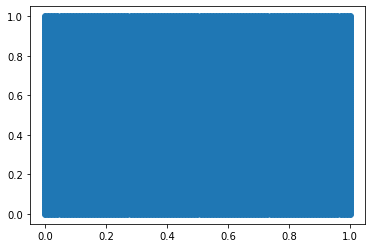

In [4]:
## Steps in x direction
nx = 100
## Steps in t direction
nt = 100

h = 1 / nx ## Step size in x direction
k = 1 / nt ## Step size in t direction

alpha = 0.05
r =  alpha * k / h**2

X, T = np.meshgrid(np.linspace(0, 1, nx + 1), np.linspace(0, 1, nt + 1))

plt.scatter(X, T)
plt.show()

In [5]:
## Initial Condition
beta = np.pi
u0 = np.sin(beta * X[0]) 

## Boundary Conditions
ux0 = 0 # u0[0] # T[:, 0]
uxn = 0 # u0[-1] # 2 - np.exp(-T[:, -1])

In [6]:
A = np.zeros((nx - 1, nx - 1))
B = np.zeros((nx - 1, nx - 1))

for i in range(nx - 1):
    A[i, i] = 2 + 2 * r
    B[i, i] = 2 - 2 * r

for i in range(nx - 2):
    A[i + 1, i] = -r
    A[i, i + 1] = -r
    B[i + 1, i] = r
    B[i, i + 1] = r

Ainv = np.linalg.inv(A)

In [7]:
## Compute Solution
u = np.zeros((nt + 1, nx + 1))
u[0] = u0
u[:, 0] = ux0
u[:, -1] = uxn

# b = np.zeros(nx - 1)
for j in range(1, nt + 1):
    # b[0] = r * u[j - 1, 0] + r * u[j, 0]
    # b[-1] = r * u[j - 1, -1] + r * u[j, -1]
    u[j, 1:nx] = Ainv @ ((B @ u[j - 1, 1:nx])) # + b)

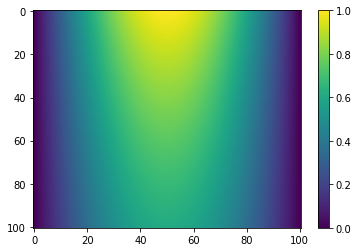

In [8]:
plt.imshow(u, aspect='auto')
plt.colorbar()
plt.show()

In [9]:
## Number of Samples 
n = 10000
## Output
data_in = []
data_out = []

## Generate Data
for _ in range(n):
    beta = np.random.uniform(-10, 10)
    beta_mat = beta * np.ones((nt + 1, nx + 1))

    u0 = np.sin(beta * X[0])

    data_in.append([beta_mat, X, T])

    ## Create Solution Matrix
    u = np.zeros((nt + 1, nx + 1))
    u[0] = u0
    u[:, 0] = ux0
    u[:, -1] = uxn

    # b = np.zeros(nx - 1)
    for j in range(1, nt + 1):
        # b[0] = r * u[j - 1, 0] + r * u[j, 0]
        # b[-1] = r * u[j - 1, -1] + r * u[j, -1]
        u[j, 1:nx] = Ainv @ ((B @ u[j - 1, 1:nx])) # + b)

    data_out.append(u)

In [10]:
data_in = np.array(torch.tensor(data_in).float())
data_out = np.array(torch.tensor(data_out).float().unsqueeze(1))

C:\Users\Harris\AppData\Local\Temp\ipykernel_8248\974941267.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:204.)
  data_in = np.array(torch.tensor(data_in).float())


In [11]:
## Data Loader
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class CustomDataset(Dataset):
    def __init__(self, t, x):
        self.t = t
        self.x = x

    def __len__(self):
        return len(self.t)
    
    def __getitem__(self, index):
        return self.t[index], self.x[index]

data = CustomDataset(data_in, data_out)

In [12]:
data[0][0]

array([[[0.9762701, 0.9762701, 0.9762701, ..., 0.9762701, 0.9762701,
         0.9762701],
        [0.9762701, 0.9762701, 0.9762701, ..., 0.9762701, 0.9762701,
         0.9762701],
        [0.9762701, 0.9762701, 0.9762701, ..., 0.9762701, 0.9762701,
         0.9762701],
        ...,
        [0.9762701, 0.9762701, 0.9762701, ..., 0.9762701, 0.9762701,
         0.9762701],
        [0.9762701, 0.9762701, 0.9762701, ..., 0.9762701, 0.9762701,
         0.9762701],
        [0.9762701, 0.9762701, 0.9762701, ..., 0.9762701, 0.9762701,
         0.9762701]],

       [[0.       , 0.01     , 0.02     , ..., 0.98     , 0.99     ,
         1.       ],
        [0.       , 0.01     , 0.02     , ..., 0.98     , 0.99     ,
         1.       ],
        [0.       , 0.01     , 0.02     , ..., 0.98     , 0.99     ,
         1.       ],
        ...,
        [0.       , 0.01     , 0.02     , ..., 0.98     , 0.99     ,
         1.       ],
        [0.       , 0.01     , 0.02     , ..., 0.98     , 0.99     ,
   

In [13]:
data[0][0].shape

(3, 101, 101)

In [14]:
dataloader = DataLoader(data, batch_size=16, shuffle=True)

## Build Network

In [15]:
## Get Device for Training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device.')

Using cpu device.


In [16]:
## Fourier Integral Kernel 2D
class FourierIntegralKernel2D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, modes1: int, modes2: int):
        super(FourierIntegralKernel2D, self).__init__()
        '''
        '''
        self.in_channels = in_channels
        self.out_channels = out_channels 
        self.modes1 = modes1 
        self.modes2 = modes2
        ## Set (random) weights for the linear transform
        weights1 = torch.rand(self.modes1, self.modes2, self.out_channels, self.in_channels, dtype=torch.cfloat) 
        self.weights1 = nn.Parameter(weights1 / (self.in_channels * self.out_channels)) ## Optional: Scale weights
        weights2 = torch.rand(self.modes1, self.modes2, self.out_channels, self.in_channels, dtype=torch.cfloat) 
        self.weights2 = nn.Parameter(weights2 / (self.in_channels * self.out_channels))

    def forward(self, v: torch.Tensor) -> torch.Tensor:
        '''
        FFT -> Linear Transform -> Inverse FFT
        '''
        ## FFT
        # print(f'v: {v.shape}')
        v_rfft = torch.fft.rfft2(v)
        # print(f'v_rfft: {v_rfft.shape}')

        ## Linear Transform 
        lv_rfft = torch.zeros(v_rfft.shape, dtype=torch.cfloat)
        # lv_rfft[:, :, :self.modes] = torch.einsum('koi, bki -> bko', self.weights, v_rfft[:, :, :self.modes].permute(0, 2, 1)).permute(0, 2, 1) ## TODO: Should I have 5 dimensions here?
        lv_rfft[:, :, :self.modes1, :self.modes2] = torch.einsum('kloi, bkli -> bklo', self.weights1, v_rfft[:, :, :self.modes1, :self.modes2].permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        # print(f'lv_rfft: {lv_rfft[0][0][:10, :10].shape}')
        # print(f'lv_rfft: {lv_rfft[0][0][:10, :10]}')    
        lv_rfft[:, :, -self.modes1:, :self.modes2] = torch.einsum('kloi, bkli -> bklo', self.weights2, v_rfft[:, :, -self.modes1:, :self.modes2].permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

        ## Inverse FFT
        v2 = torch.fft.irfft2(lv_rfft, s=(v.shape[-2], v.shape[-1]))
        # print(f'v2: {v2.shape}')
        return v2
        

In [17]:
## Fourier Network Operator 2D
class FourierNetworkOperator2D(nn.Module):
    def __init__(self, da: int, du: int, width: int, modes1: int, modes2: int):
        super(FourierNetworkOperator2D, self).__init__()
        '''
        '''
        self.width = width
        self.modes1 = modes1
        self.modes2 = modes2

        ## P: Lifts the lower dimensional function to higher dimensional space
        self.P = nn.Conv2d(da, self.width, 1) ## TODO: Change da

        ## K: Fourier integral kernel operator
        self.k0 = FourierIntegralKernel2D(self.width, self.width, self.modes1, self.modes2)
        self.k1 = FourierIntegralKernel2D(self.width, self.width, self.modes1, self.modes2)
        self.k2 = FourierIntegralKernel2D(self.width, self.width, self.modes1, self.modes2)
        self.k3 = FourierIntegralKernel2D(self.width, self.width, self.modes1, self.modes2)
        self.k4 = FourierIntegralKernel2D(self.width, self.width, self.modes1, self.modes2)
        self.k5 = FourierIntegralKernel2D(self.width, self.width, self.modes1, self.modes2)
        self.k6 = FourierIntegralKernel2D(self.width, self.width, self.modes1, self.modes2)
        self.k7 = FourierIntegralKernel2D(self.width, self.width, self.modes1, self.modes2)
        self.k8 = FourierIntegralKernel2D(self.width, self.width, self.modes1, self.modes2)
        self.k9 = FourierIntegralKernel2D(self.width, self.width, self.modes1, self.modes2)

        ## W: Pointwise linear operator
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.w4 = nn.Conv2d(self.width, self.width, 1)
        self.w5 = nn.Conv2d(self.width, self.width, 1)
        self.w6 = nn.Conv2d(self.width, self.width, 1)
        self.w7 = nn.Conv2d(self.width, self.width, 1)
        self.w8 = nn.Conv2d(self.width, self.width, 1)
        self.w9 = nn.Conv2d(self.width, self.width, 1)

        ## Q: Projects the higher dimensional function to lower dimensional space
        self.Q = nn.Conv2d(self.width, du, 1) ## TODO: Change du

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        '''
        '''
        ## P
        x = self.P(x)

        ## Fourier Layer #0
        ## K
        x1 = self.k0(x)
        ## W
        x2 = self.w0(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #1
        ## K
        x1 = self.k1(x)
        ## W
        x2 = self.w1(x)
        ## Sum 
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #2
        ## K
        x1 = self.k2(x)
        ## W
        x2 = self.w2(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #3
        ## K
        x1 = self.k3(x)
        ## W
        x2 = self.w3(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #4
        ## K
        x1 = self.k4(x)
        ## W
        x2 = self.w4(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #5
        ## K
        x1 = self.k5(x)
        ## W
        x2 = self.w5(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #6
        ## K
        x1 = self.k6(x)
        ## W
        x2 = self.w6(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #7
        ## K
        x1 = self.k7(x)
        ## W
        x2 = self.w7(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #8
        ## K
        x1 = self.k8(x)
        ## W
        x2 = self.w8(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Fourier Layer #9
        ## K
        x1 = self.k9(x)
        ## W
        x2 = self.w9(x)
        ## Sum
        x = x1 + x2
        ## Gelu
        x = nn.functional.gelu(x)
        # x = nn.functional.gelu(x1)
        # x = nn.functional.gelu(x2)

        ## Q
        x = self.Q(x)
        return x


In [18]:
import operator
from functools import reduce

def count_parameters(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, list(p.size() + (2, ) if p.is_complex() else p.size()))
    return c

model = FourierNetworkOperator2D(3, 1, width=64, modes1=4, modes2=4)
print(f'Number of parameters: {count_parameters(model)}')

Number of parameters: 2663361


## Train

In [19]:
## Model Parameters
learning_rate = 1e-3
epochs = 5

In [20]:
## Loss Function
loss_function = nn.MSELoss()

In [21]:
## Optimizer 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

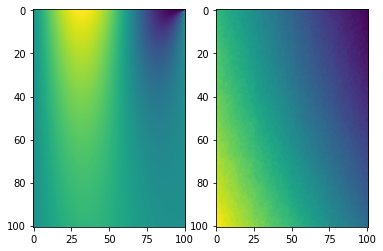

In [22]:
## Test 0
## Initial Condition
betat0 = np.random.uniform(-10, 10)
beta_matt0 = betat0 * torch.from_numpy(np.ones((nt + 1, nx + 1))).float().unsqueeze(0).unsqueeze(0)

## Compute Solution
ut0 = np.zeros((nt + 1, nx + 1))
ut0[0] = np.sin(betat0 * X[0]) 
ut0[:, 0] = ux0
ut0[:, -1] = uxn

# b = np.zeros(nx - 1)
for j in range(1, nt + 1):
    # b[0] = r * u[j - 1, 0] + r * u[j, 0]
    # b[-1] = r * u[j - 1, -1] + r * u[j, -1]
    ut0[j, 1:nx] = Ainv @ ((B @ ut0[j - 1, 1:nx])) # + b)

upredt0 = model(torch.cat((beta_matt0, torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0), torch.from_numpy(T).float().unsqueeze(0).unsqueeze(0)), 1))
# print(upredt0.shape)

plt.subplot(121)
plt.imshow(ut0, aspect='auto')
plt.subplot(122)
plt.imshow(upredt0.detach()[0][0], aspect='auto')
plt.show()

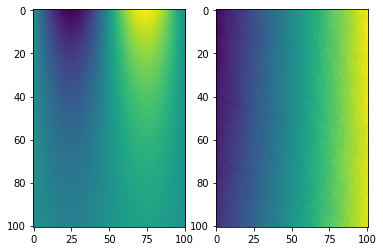

In [23]:
## Test 1
## Initial Condition
betat1 = np.random.uniform(-10, 10)
beta_matt1 = betat1 * torch.from_numpy(np.ones((nt + 1, nx + 1))).float().unsqueeze(0).unsqueeze(0)

## Compute Solution
ut1 = np.zeros((nt + 1, nx + 1))
ut1[0] = np.sin(betat1 * X[0]) 
ut1[:, 0] = ux0
ut1[:, -1] = uxn

# b = np.zeros(nx - 1)
for j in range(1, nt + 1):
    # b[0] = r * u[j - 1, 0] + r * u[j, 0]
    # b[-1] = r * u[j - 1, -1] + r * u[j, -1]
    ut1[j, 1:nx] = Ainv @ ((B @ ut1[j - 1, 1:nx])) # + b)

upredt1 = model(torch.cat((beta_matt1, torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0), torch.from_numpy(T).float().unsqueeze(0).unsqueeze(0)), 1))

plt.subplot(121)
plt.imshow(ut1, aspect='auto')
plt.subplot(122)
plt.imshow(upredt1.detach()[0][0], aspect='auto')
plt.show()

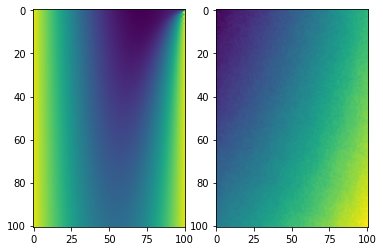

In [24]:
## Test 2
## Initial Condition
betat2 = np.random.uniform(-10, 10)
beta_matt2 = betat2 * torch.from_numpy(np.ones((nt + 1, nx + 1))).float().unsqueeze(0).unsqueeze(0)

## Compute Solution
ut2 = np.zeros((nt + 1, nx + 1))
ut2[0] = np.sin(betat2 * X[0]) 
ut2[:, 0] = ux0
ut2[:, -1] = uxn

# b = np.zeros(nx - 1)
for j in range(1, nt + 1):
    # b[0] = r * u[j - 1, 0] + r * u[j, 0]
    # b[-1] = r * u[j - 1, -1] + r * u[j, -1]
    ut2[j, 1:nx] = Ainv @ ((B @ ut2[j - 1, 1:nx])) # + b)

upredt2 = model(torch.cat((beta_matt2, torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0), torch.from_numpy(T).float().unsqueeze(0).unsqueeze(0)), 1))

plt.subplot(121)
plt.imshow(ut2, aspect='auto')
plt.subplot(122)
plt.imshow(upredt2.detach()[0][0], aspect='auto')
plt.show()

In [25]:
## Training Loop
def train_loop(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)
    for batch, (t, x) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(t)
        loss = loss_function(pred, x)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(t)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [26]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(dataloader, model, loss_function, optimizer)
print("Done!")

Epoch 1
-------------------------------
loss: 0.171860  [    0/10000]
loss: 0.005559  [ 1600/10000]
loss: 0.002578  [ 3200/10000]
loss: 0.002011  [ 4800/10000]
loss: 0.002880  [ 6400/10000]
loss: 0.000925  [ 8000/10000]
loss: 0.000751  [ 9600/10000]
Epoch 2
-------------------------------
loss: 0.000526  [    0/10000]
loss: 0.001489  [ 1600/10000]
loss: 0.000604  [ 3200/10000]
loss: 0.000531  [ 4800/10000]
loss: 0.000316  [ 6400/10000]
loss: 0.000321  [ 8000/10000]
loss: 0.019255  [ 9600/10000]
Epoch 3
-------------------------------
loss: 0.007865  [    0/10000]
loss: 0.000387  [ 1600/10000]
loss: 0.000280  [ 3200/10000]
loss: 0.001043  [ 4800/10000]
loss: 0.000198  [ 6400/10000]
loss: 0.000133  [ 8000/10000]
loss: 0.000112  [ 9600/10000]
Epoch 4
-------------------------------
loss: 0.000132  [    0/10000]
loss: 0.000441  [ 1600/10000]
loss: 0.001228  [ 3200/10000]
loss: 0.000152  [ 4800/10000]
loss: 0.000241  [ 6400/10000]
loss: 0.000152  [ 8000/10000]
loss: 0.000084  [ 9600/10000]


## Test

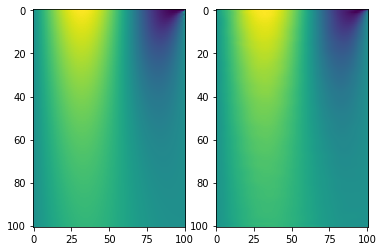

In [27]:
## Test 0
upredt0 = model(torch.cat((beta_matt0, torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0), torch.from_numpy(T).float().unsqueeze(0).unsqueeze(0)), 1))

plt.subplot(121)
plt.imshow(ut0, aspect='auto')
plt.subplot(122)
plt.imshow(upredt0.detach()[0][0], aspect='auto')
plt.show()

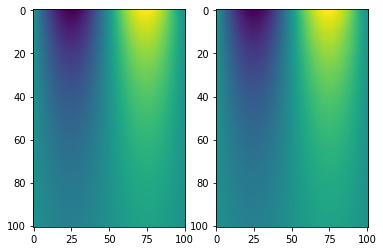

In [28]:
## Test 1
upredt1 = model(torch.cat((beta_matt1, torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0), torch.from_numpy(T).float().unsqueeze(0).unsqueeze(0)), 1))

plt.subplot(121)
plt.imshow(ut1, aspect='auto')
plt.subplot(122)
plt.imshow(upredt1.detach()[0][0], aspect='auto')
plt.show()

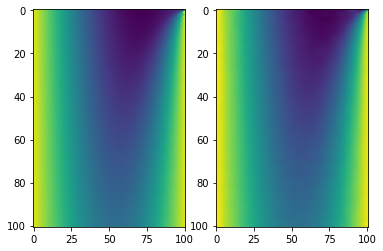

In [29]:
## Test 2
upredt2 = model(torch.cat((beta_matt2, torch.from_numpy(X).float().unsqueeze(0).unsqueeze(0), torch.from_numpy(T).float().unsqueeze(0).unsqueeze(0)), 1))

plt.subplot(121)
plt.imshow(ut2, aspect='auto')
plt.subplot(122)
plt.imshow(upredt2.detach()[0][0], aspect='auto')
plt.show()